In [ ]:
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
import os
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

state_size = 3
action_size = 2

# Implement mixed-precision training for potential performance improvement
scaler = GradScaler()

class Card:
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit
        self.value = self.determine_value()

    def determine_value(self):
        if self.rank in ['Jack', 'Queen', 'King']:
            return 10
        elif self.rank == 'Ace':
            return 11
        return int(self.rank)

class Deck:
    def __init__(self):
        self.reset()

    def reset(self):
        ranks = [str(n) for n in range(2, 11)] + ['Jack', 'Queen', 'King', 'Ace']
        suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
        self.cards = [Card(rank, suit) for suit in suits for rank in ranks]
        self.reshuffle()

    def reshuffle(self):
        random.shuffle(self.cards)

    def deal(self):
        if len(self.cards) < 15:  # Reshuffle if deck is running low
            self.reset()
        return self.cards.pop()

class Player:
    def __init__(self, name):
        self.name = name
        self.reset()

    def add_card(self, card):
        self.hand.append(card)
        self.adjust_for_ace()

    def adjust_for_ace(self):
        self.value = sum(card.value for card in self.hand)
        aces = sum(card.rank == 'Ace' for card in self.hand)
        while self.value > 21 and aces:
            self.value -= 10
            aces -= 1

    def reset(self):
        self.hand = []
        self.value = 0

class Dealer(Player):
    def show_first_card(self):
        return self.hand[0] if self.hand else None

class DQNNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent(Player):
    def __init__(self):
        super().__init__("DQN Agent")
        self.state_size = state_size
        self.action_size = action_size

        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001

        self.model = DQNNetwork(self.state_size, self.action_size).to(device)
        self.target_model = DQNNetwork(self.state_size, self.action_size).to(device)
        self.update_target_model()

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()
        self.batch_size = 32

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        state = torch.FloatTensor(state).to(device)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        self.model.eval()
        with torch.no_grad():
            act_values = self.model(state)
        self.model.train()
        return np.argmax(act_values.cpu().data.numpy())

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:

            state = torch.FloatTensor(state).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            action = torch.LongTensor([action]).to(device)
            reward = torch.FloatTensor([reward]).to(device)
            done = torch.BoolTensor([done]).to(device)

            # Mixed-precision training
            with autocast():

                current_q = self.model(state).gather(1, action.unsqueeze(1)).squeeze(1)

                next_q = self.target_model(next_state).detach().max(1)[0]
                expected_q = reward + (1 - done.int()) * self.gamma * next_q

                loss = F.mse_loss(current_q.squeeze(), expected_q)

            self.optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # Load and save functions will need to be adapted for PyTorch
    def load(self, name):
        self.model.load_state_dict(torch.load(name))

    def save(self, name):
        torch.save(self.model.state_dict(), name)

class BlackjackGame:
    def __init__(self):
        self.player = DQNAgent()
        self.dealer = Dealer("Dealer")
        self.deck = Deck()

    def reset_deck(self):
        self.deck = Deck()

    def play_round(self, learn=False):
        self.reset_deck()
        self.player.reset()
        self.dealer.reset()
        done = False

        # Deal two cards each
        for _ in range(2):
            self.player.add_card(self.deck.deal())
            self.dealer.add_card(self.deck.deal())

        # Player's turn
        while self.player.value < 21:
            state = self.get_state(self.player, self.dealer)
            action = self.player.act(state)  # DQN decides
            if action == 0:
                self.player.add_card(self.deck.deal())
            else:
                break # Stand

            next_state = self.get_state(self.player, self.dealer)
            done = self.player.value > 21 or action == 1
            reward = 0 if not done else self.calculate_reward(self.player, self.dealer)

            # Store the experience in replay memory
            if learn:
                self.player.remember(state, action, reward, next_state, done)

            if done:
                break

        # Dealer's turn
        while not done and self.dealer.value < 17:
            self.dealer.add_card(self.deck.deal())

        outcome = self.determine_outcome()  # Determine game outcome

        # Learning part: replay to train neural network
        if learn:
            self.player.replay()
            self.player.update_target_model()

        return outcome
    def get_state(self, player, dealer):
        dealer_first_card_value = dealer.show_first_card().value if dealer.show_first_card() else 0
        has_ace = 1 if any(card.rank == 'Ace' for card in player.hand) else 0
        return np.array([player.value, dealer_first_card_value, has_ace]).reshape(1, -1)

    def calculate_reward(self, player, dealer):
        if player.value > 21:
            return -1
        elif dealer.value > 21 or player.value > dealer.value:
            return 1
        elif player.value < dealer.value:
            return -1
        return 0


    def determine_outcome(self):
        if self.player.value > 21:
            return 'Player busts'
        elif self.dealer.value > 21:
            return 'Dealer busts'
        elif self.player.value > self.dealer.value:
            return 'Player wins'
        elif self.player.value < self.dealer.value:
            return 'Dealer wins'
        else:
            return 'Push'

def train_agent(rounds=1000000, save_filename='dqn.weights.pth'):
    game = BlackjackGame()

    if os.path.exists(save_filename):
        game.player.load(save_filename)
        print(f"Loaded weights from {save_filename}")
    else:
        print(f"No pretrained weights file found at {save_filename}. Proceeding without loading.")

    outcomes = {'Player wins': 0, 'Dealer wins': 0, 'Player busts': 0, 'Dealer busts': 0, 'Push': 0}
    total_games = 0

    for i in tqdm(range(1, rounds + 1), desc="Training Progress"):
        outcome = game.play_round(learn=True)
        outcomes[outcome] += 1
        total_games += 1

        if i % 100 == 0:  # Print metrics every 100 rounds
            print(f"\nAfter {i} rounds:")
            for outcome, count in outcomes.items():
                print(f"{outcome}: {round((count / total_games) * 100, 2)}%")
            outcomes = {'Player wins': 0, 'Dealer wins': 0, 'Player busts': 0, 'Dealer busts': 0, 'Push': 0}
            total_games = 0

        if i % 10000 == 0:
            game.player.save(save_filename)

    game.player.save(save_filename)
    print("Training completed.")

train_agent(rounds=10000)


No pretrained weights file found at dqn.weights.pth. Proceeding without loading.


Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-10-8b062821f5ef>:152: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(current_q.squeeze(), expected_q)
Training Progress:   1%|          | 101/10000 [00:05<13:31, 12.20it/s]


After 100 rounds:
Player wins: 12.0%
Dealer wins: 37.0%
Player busts: 31.0%
Dealer busts: 15.0%
Push: 5.0%


Training Progress:   1%|          | 103/10000 [00:06<13:48, 11.95it/s]<ipython-input-10-8b062821f5ef>:142: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.BoolTensor([done]).to(device)
Training Progress:   2%|▏         | 202/10000 [00:14<14:37, 11.17it/s]


After 200 rounds:
Player wins: 9.0%
Dealer wins: 50.0%
Player busts: 16.0%
Dealer busts: 22.0%
Push: 3.0%


Training Progress:   3%|▎         | 302/10000 [00:22<13:13, 12.23it/s]


After 300 rounds:
Player wins: 7.0%
Dealer wins: 55.0%
Player busts: 11.0%
Dealer busts: 23.0%
Push: 4.0%


Training Progress:   4%|▍         | 401/10000 [00:31<13:16, 12.05it/s]


After 400 rounds:
Player wins: 13.0%
Dealer wins: 48.0%
Player busts: 5.0%
Dealer busts: 29.0%
Push: 5.0%


Training Progress:   5%|▌         | 501/10000 [00:40<13:13, 11.97it/s]


After 500 rounds:
Player wins: 9.0%
Dealer wins: 51.0%
Player busts: 6.0%
Dealer busts: 31.0%
Push: 3.0%


Training Progress:   6%|▌         | 583/10000 [00:46<13:16, 11.83it/s]


Testing the trained agent with detailed metrics and plotting performance:


100%|██████████| 2500/2500 [00:00<00:00, 7408.32it/s]


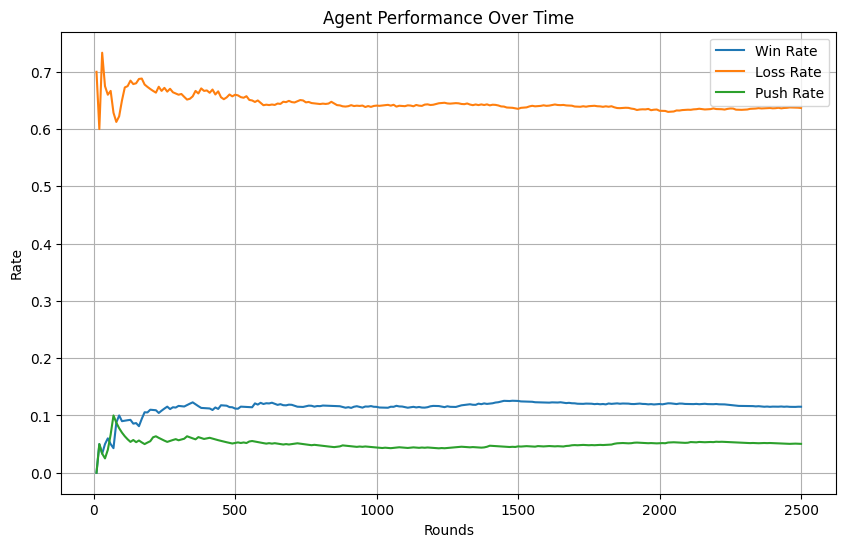

Player wins: 288
Dealer wins: 870
Player busts: 722
Dealer busts: 494
Push: 126


In [62]:
def test_agent(rounds=1000, load_filename='dqn.weights.pth', report_interval=100):
    game = BlackjackGame()
    game.player.load(load_filename)

    # Initialize metrics
    results = {'Player wins': 0, 'Dealer wins': 0, 'Player busts': 0, 'Dealer busts': 0, 'Push': 0}
    win_rates = []
    loss_rates = []
    push_rates = []
    intervals = []

    for i in tqdm(range(1, rounds + 1)):
        result = game.play_round(learn=False)
        results[result] += 1

        # Report and collect metrics at each interval
        if i % report_interval == 0 or i == rounds:
            total_games = sum(results.values())
            win_rate = results['Player wins'] / total_games
            loss_rate = (results['Dealer wins'] + results['Player busts']) / total_games
            push_rate = results['Push'] / total_games
            win_rates.append(win_rate)
            loss_rates.append(loss_rate)
            push_rates.append(push_rate)
            intervals.append(i)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(intervals, win_rates, label='Win Rate')
    plt.plot(intervals, loss_rates, label='Loss Rate')
    plt.plot(intervals, push_rates, label='Push Rate')
    plt.xlabel('Rounds')
    plt.ylabel('Rate')
    plt.title('Agent Performance Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print final metrics
    for outcome, count in results.items():
        print(f"{outcome}: {count}")

print("\nTesting the trained agent with detailed metrics and plotting performance:")
test_agent(rounds=2500, report_interval=10)